# **MG&G Datascience Tutorial**

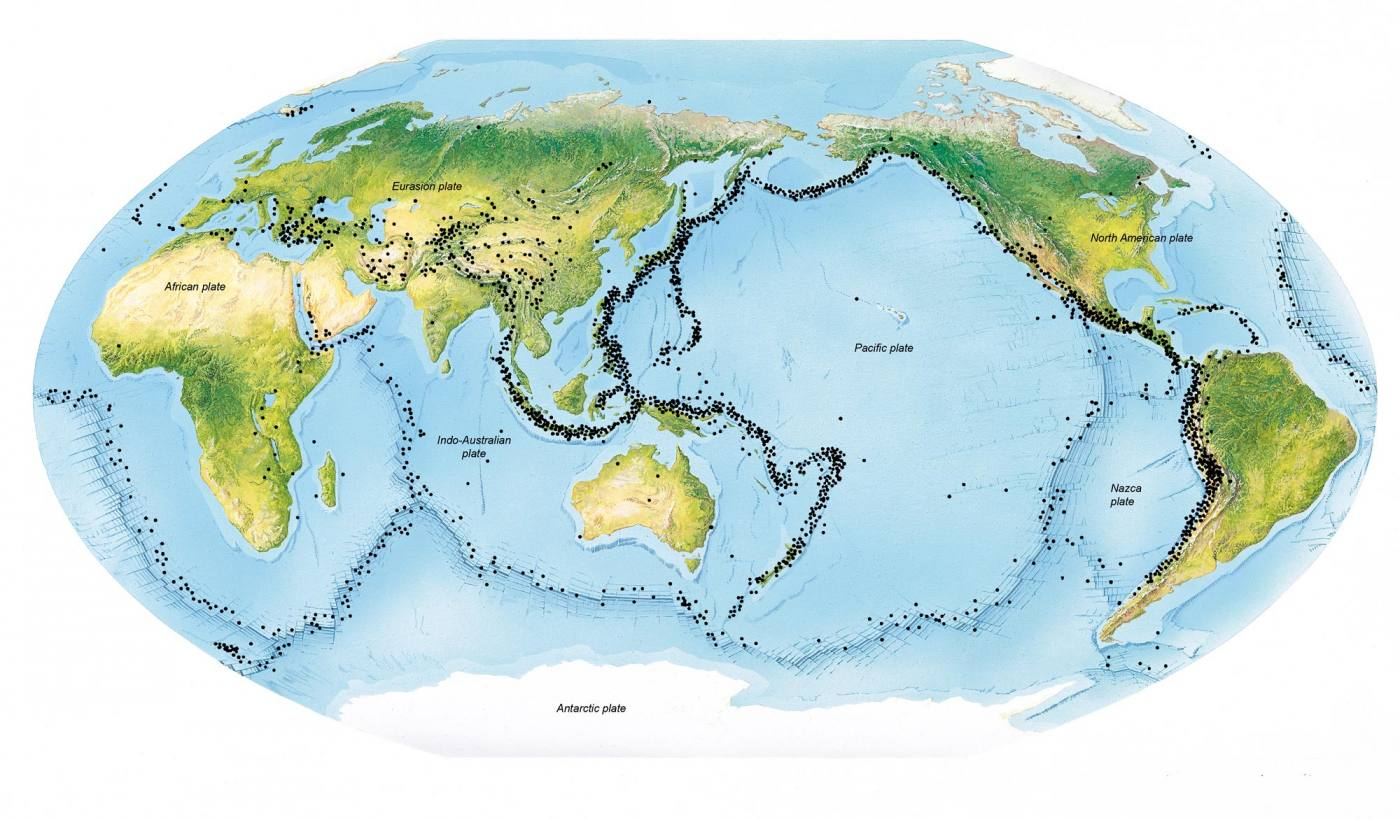

This tutorial is part of our Marine Geology and Geophysics day. It demonstrates how to do basic analysis and visualization of seafloor features, geologic, and seismic data. We will learn how to make maps of publicly available datasets of seafloor bathymetry, crustal age, and tectonic plate depth. We will then learn how to download data using python from the databases where seismic data are stored. Combining these techniques, we will learn to think like a geophysicist and use available data to draw connections between earthquake activity and geologic characteristics.

## **Tutorial Goals**


*   Python Skills
  *   List item
  *   List item


*   MG&G Knowledge
  *   Learn about how earth processes are derived from the bathymetry
  *   List item


### **Reading**

Bilek, Susan L., Susan Y. Schwartz, and Heather R. DeShon. "Control of seafloor roughness on earthquake rupture behavior." Geology 31.5 (2003): 455-458.

https://pubs.geoscienceworld.org/gsa/geology/article/31/5/455/198278/Control-of-seafloor-roughness-on-earthquake

# **Environment set-up**

to be filled out with instructions for new environment set-up

# Downloading earthquake data

In [ ]:
# Prepare to connect to the earthquake database, called IRIS

import obspy
from obspy.clients.fdsn import Client
client = Client("IRIS")

In [ ]:
# Specify what times you want the data for
t1 = obspy.UTCDateTime(2006,7,1)
t2 = obspy.UTCDateTime(2007,7,1)

# Specify the minimum magnitude earthquake you want
minmagnitude = 6.5

In [ ]:
# Query the database for earthquakes within your timeframe
cat = client.get_events(starttime = t1, endtime = t2,minmagnitude=minmagnitude)

In [ ]:
# This returns an earthquake catalog object, which we can reorganize into a pandas dataframe
times = [ev.origins[0].time.datetime for ev in cat]
lats = [ev.origins[0].latitude for ev in cat]
lons = [ev.origins[0].longitude for ev in cat]
mags = [ev.magnitudes[0].mag for ev in cat]
depths = [ev.origins[0].depth for ev in cat]

origin_dict = {'time':times,'latitude':lats,'longitude':lons,'depth':depths,'magnitude':mags}

events = pd.DataFrame.from_dict(origin_dict)
events['time'] = [str(t) for t in events['time']]
events.head()

# Interactive maps of global earthquakes

In [ ]:
# here the plotly code

In [ ]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import geopandas as gpd

As you can see on the interactive maps, a particularly active location is an area off the coast of the northwest United States. To see why this might be, we can look at the topography of the seafloor in that area. We call seafloor topography data "bathymetry".


# Detailed non-interactive maps

Download bathymetry grid. We will request it using a URL request.

In [ ]:
# Urllib is a built in library in python
import urllib.request 

In [ ]:
# Specify coordinates
minlat = 40
maxlat = 50
minlon = -131 
maxlon = -123

In [ ]:
# We build a URL which will automatically download a bathymetry grid to our specifications
url = 'https://www.gmrt.org/services/GridServer?north=' + str(maxlat) + '&west=' + str(minlon) + '&east=' + str(maxlon) + '&south=' + str(minlat) + '&layer=topo&format=netcdf&resolution=high' 
print(url)

In [ ]:
# The grid will download to your current directory
urllib.request.urlretrieve(url,'cascadia_bathy.nc')

Great, now we have our bathymetry grid! To make nice maps, a tool most geophysicists use is called GMT (Geophysical Mapping Tools).

It now has a nice implementation as a python package called pyGMT.

Let's use that to plot up our bathymetry!

In [ ]:
import pygmt

topo_data = 'cascadia_bathy.nc'

In [ ]:
fig = pygmt.Figure()

# Plot the grid data
fig.grdimage(
    grid=topo_data,
    region=[minlon, maxlon, minlat, maxlat],
    projection='M4i',
    shading=True,
    frame=True
    )

# Plot the coastlines
fig.coast(shorelines="1/0.5p")

fig.show()

Do any features in the bathymetry stand out to you?

Let's see how our earthquake locations relate to bathymetry.

In [ ]:
# Plot x/y points
fig.plot(
    x=lons,
    y=lats,
    style='c0.1i',
    color='red',
    pen='black',
    label='something',
    )
fig.show()

We can see there aren't too many large earthquakes occurring throughout the whole region. To get a better sense of the full scope of activity, we should plot smaller earthquakes.

# IN-CLASS EXERCISE NUMBER 1: 
Download earthquakes with a minimum magnitude of 2.5 for the chosen region from IRIS. Plot those earthquakes on the bathymetry map, with their size relating to magnitude.

We see that many of the earthquakes align with the bathymetric high that runs roughly north-south in the region. That is called the Juan de Fuca Ridge... (add paper here?)

# Time Series Data - Earthquake Waveforms

The data we have been looking at, earthquake catalogs, were derived from observations of ground motion made using seismometers.

We wouldn't be real geophysicists if we didn't look at this ground motion data and see what an earthquake actually looks like in time series.

In [ ]:
# See which seismic stations exist in our area of interest
# This is done the same way we pulled in earthquakes- by connecting to the IRIS client

# Let's look specifically at the seismometers on the Ocean Observatories Initiative cabled network
inventory = client.get_stations(network="OO",
                                starttime=t1,
                                endtime=t2,
                               minlatitude = minlat, maxlatitude = maxlat, minlongitude = minlon, maxlongitude = maxlon)

In [ ]:
# Some code looking at what's included in the inventory...

# IN-CLASS EXERCISE NUMBER 2:

Plot the locations of these seismic stations on your bathymetry map using triangle symbols. Hint: triangle symbol is denoted by ...

Here a little blurb and links about the OOI... And Axial Seamount...

In [ ]:
# Let's find the time that the largest earthquake occurs in our catalog
eq_time = ...

In [ ]:
# Let's query the time series data for an hour surrounding that earthquake time

# Let's gather the information we need to query seismic waveforms

# A start and end time, let's call it 30 minutes before and after the pick time
t1 = eq_time - 30*60
t2 = eq_time + 30*60

# Now let's decide what station we want to pull data frome
# It has a network code, station code, location code, and several channels
# We can pull all channels of data from the station using a wildcard
network = pick.waveform_id.network_code
station = pick.waveform_id.station_code
location = pick.waveform_id.location_code
channel = pick.waveform_id.channel_code[0:2] + '*'



# Download the waveform, still using the IRIS client!
stream = client.get_waveforms(network,station,location,channel,t1,t2)

Now we have a "stream" object, which contains multiple channels of time series data.

We can plot it up nicely using the built in functions- let's look at the raw data. We can see the earthquake arrive in the middle of the window.

In [ ]:
stream.plot()

We see that each channel has metadata associated with it, including sampling rate information. Each channel is a separate "Trace" object.


In [ ]:
print(stream)
print(stream[0].stats)

The actual time series data is stored as a numpy array with each trace.

In [ ]:
stream[0].data

We can easily filter the waveforms using built in functions and see the difference in the plot.

In [ ]:
stream.filter('bandpass',freqmin=5,freqmax=15)
stream.plot();

This process of pulling in waveforms is highly flexible and can be done for any stations available in the IRIS DMC. This is a useful page to play around and browse what's available from IRIS:
http://ds.iris.edu/gmap/#network=XO&starttime=2013-01-01T00:00:00&endtime=2599-12-31T23:59:59&planet=earth